<h1><center><B><font color = 'dark blue'> Speech Emotion Recognition </b></font></center></h1>

<h2><b><font color = 'darkblue'>Imports </b></h2>

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

import random

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM, Bidirectional
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

<h2><b><font color = 'darkblue'>Download datasets and reformat them</b></h2>

In [ ]:
TESS = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/"
RAVDESS = "/kaggle/input/ravdess-emotional-speech-audio/"
SAVEE = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"
CREMA = "/kaggle/input/cremad/AudioWAV/"

<h2><b><font color = 'darkblue'>1- RAVDESS </b></h2>

In [ ]:
dir_list = os.listdir(RAVDESS)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    if i == 'audio_speech_actors_01-24':
        break
    fname = os.listdir(RAVDESS + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        #print(part[2])
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAVDESS + i + '/' + f)


Ravdess_df = pd.DataFrame(emotion)
Ravdess_df = Ravdess_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
Ravdess_df = pd.concat([pd.DataFrame(gender),Ravdess_df],axis=1)
Ravdess_df.columns = ['gender','emotion']
Ravdess_df['labels'] =Ravdess_df.gender + '_' + Ravdess_df.emotion
Ravdess_df['source'] = 'RAVDESS'
Ravdess_df = pd.concat([Ravdess_df,pd.DataFrame(path, columns = ['path'])],axis=1)
Ravdess_df = Ravdess_df.drop(['gender', 'emotion'], axis=1)
Ravdess_df.labels.value_counts()

male_neutral       144
female_neutral     144
male_sad            96
male_fear           96
male_happy          96
male_disgust        96
male_angry          96
male_surprise       96
female_surprise     96
female_disgust      96
female_fear         96
female_sad          96
female_happy        96
female_angry        96
Name: labels, dtype: int64

<h2><b><font color = 'darkblue'>2- CREMA </b></h2>

In [ ]:
dir_list = os.listdir(CREMA)
dir_list.sort()
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dir_list:
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)

CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()

male_angry        671
male_disgust      671
male_fear         671
male_happy        671
male_sad          671
female_angry      600
female_disgust    600
female_fear       600
female_happy      600
female_sad        600
male_neutral      575
female_neutral    512
Name: labels, dtype: int64

<h2><b><font color = 'darkblue'>3- TESS </b></h2>

In [ ]:
dir_list = os.listdir(TESS)

path = []
emotion = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('female_angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('female_disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('female_fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('female_happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('female_neutral')
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('female_surprise')
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('female_sad')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['labels'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.labels.value_counts()

female_fear        400
female_angry       400
female_disgust     400
female_neutral     400
female_sad         400
female_surprise    400
female_happy       400
Name: labels, dtype: int64

<h2><b><font color = 'darkblue'>4- SAVEE </b></h2>

In [ ]:
dir_list = os.listdir(SAVEE)

emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('male_angry')
    elif i[-8:-6]=='_d':
        emotion.append('male_disgust')
    elif i[-8:-6]=='_f':
        emotion.append('male_fear')
    elif i[-8:-6]=='_h':
        emotion.append('male_happy')
    elif i[-8:-6]=='_n':
        emotion.append('male_neutral')
    elif i[-8:-6]=='sa':
        emotion.append('male_sad')
    elif i[-8:-6]=='su':
        emotion.append('male_surprise')
    else:
        emotion.append('male_error')
    path.append(SAVEE + i)

SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.labels.value_counts()

male_neutral     120
male_happy        60
male_fear         60
male_disgust      60
male_angry        60
male_surprise     60
male_sad          60
Name: labels, dtype: int64

<h2><b><font color = 'darkblue'>Merge all datasets together</b></h2>

In [ ]:
# merge all data frames together
data_path = pd.concat([Ravdess_df, CREMA_df, TESS_df, SAVEE_df], axis = 0)

# save the data frame and make index=False because we will have 4 records for each index
data_path.to_csv("new_data_path.csv",index=False)
print(len(data_path))
data_path.head()

12162


,labels,source,path
0,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/A...
1,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/A...
2,male_sad,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/A...
3,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/A...
4,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/A...


In [ ]:
# read data frame and make sure that each index has one record not 4
data_path = pd.read_csv('/kaggle/input/newdatasets/new_data_path.csv')
data_path

,labels,source,path
0,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/A...
1,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/A...
2,male_sad,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/A...
3,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/A...
4,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/A...
...,...,...,...
12157,male_surprise,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
12158,male_neutral,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
12159,male_neutral,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
12160,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...


<h2><b><font color = 'darkblue'>Exploratory Data Analysis</b></h2>

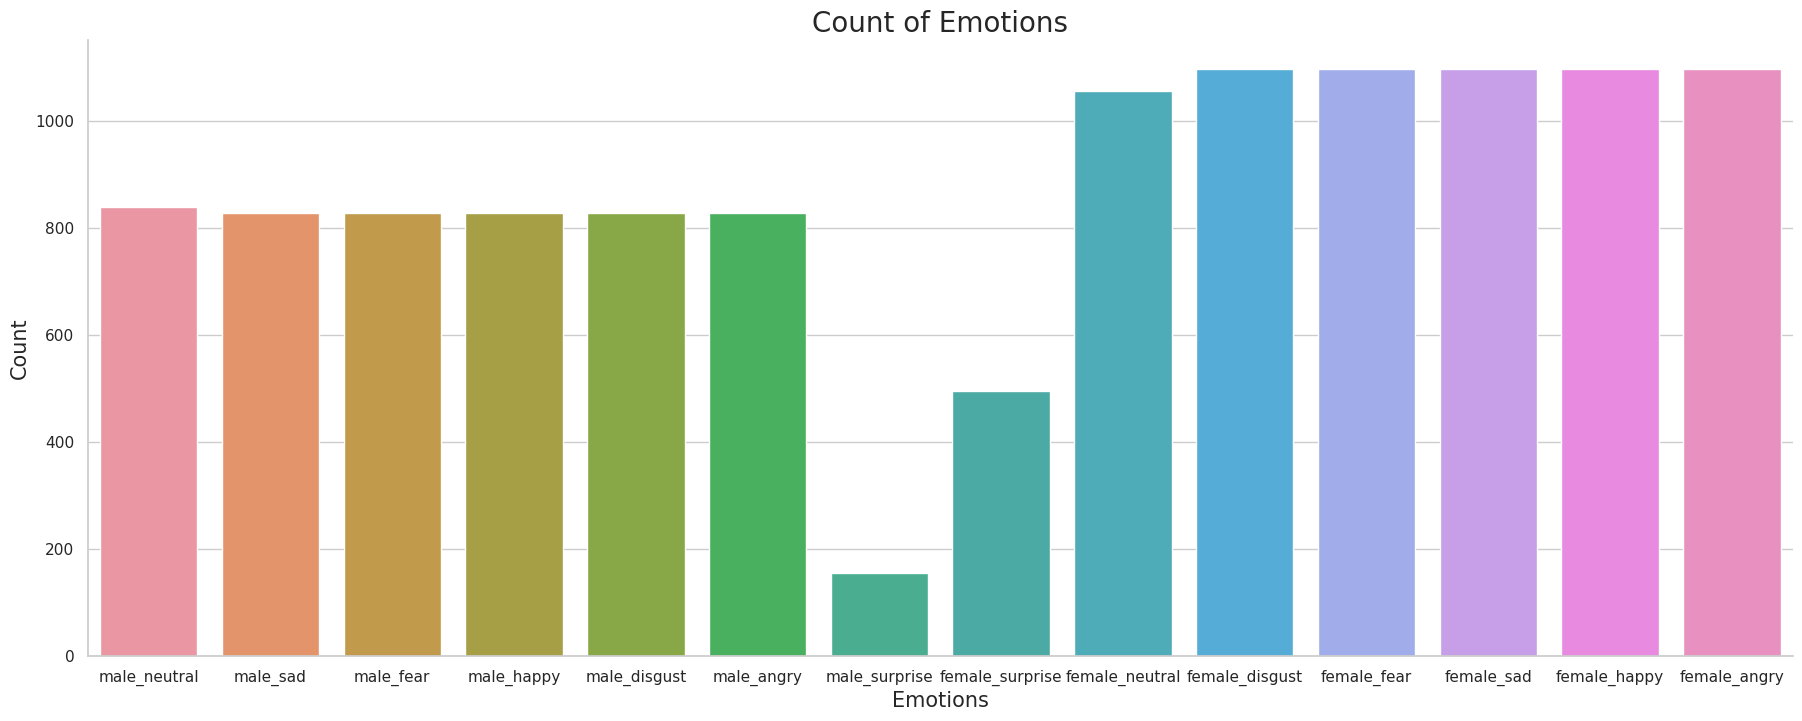

In [ ]:
plt.figure(figsize=(22,8))
sns.countplot(x=data_path.labels)
plt.ylabel('Count', size=15)
plt.xlabel('Emotions', size=15)
plt.title('Count of Emotions', size=20)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

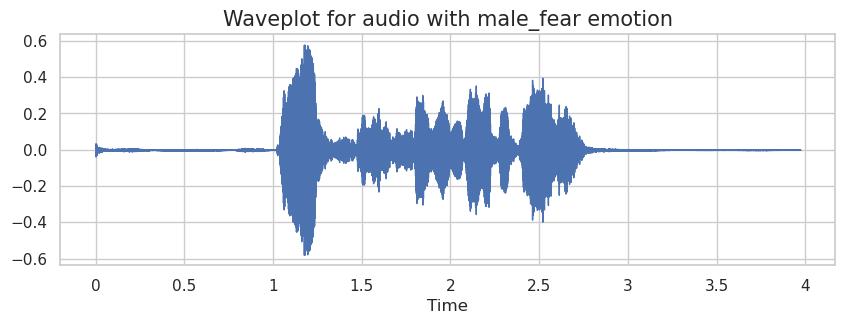

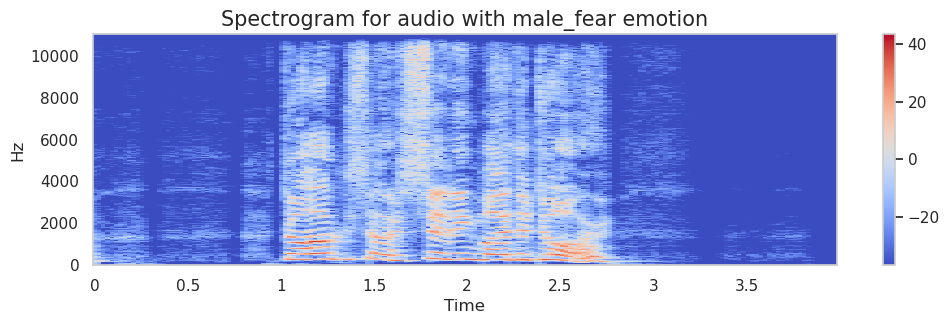

In [ ]:
emotion='male_fear'
path = np.array(data_path.path[data_path.labels==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

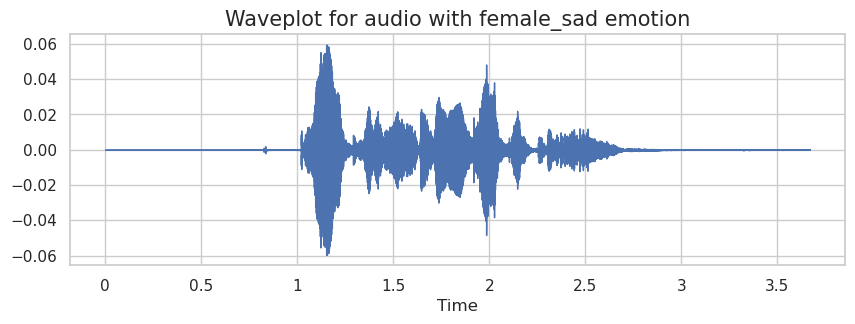

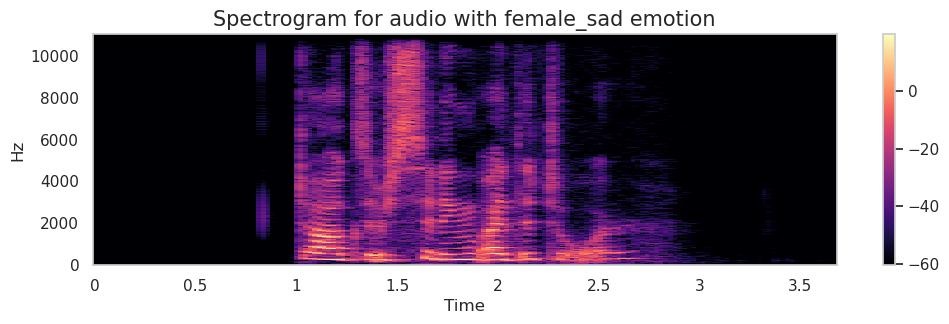

In [ ]:
emotion='female_sad'
path = np.array(data_path.path[data_path.labels==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

<h2><b><font color = 'darkblue'>Data Augmentation</b></h2>

In [ ]:
def noise(data):
    noise_amp = 0.04*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.70):
    return librosa.effects.time_stretch(data,rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

def higher_speed(data, speed_factor = 1.25):
    return librosa.effects.time_stretch(data,rate=speed_factor)

def lower_speed(data, speed_factor = 0.75):
    return librosa.effects.time_stretch(data,rate=speed_factor)


In [ ]:
def _plot_signal_and_augmented_signal(signal, augmented_signal, sr):
    fig, ax = plt.subplots(nrows=2)
    librosa.display.waveshow(signal, sr=sr, ax=ax[0])
    ax[0].set(title='Original Signal')
    librosa.display.waveshow(augmented_signal, sr=sr, ax=ax[1])
    ax[1].set(title='Augmented Signal')
    plt.show()

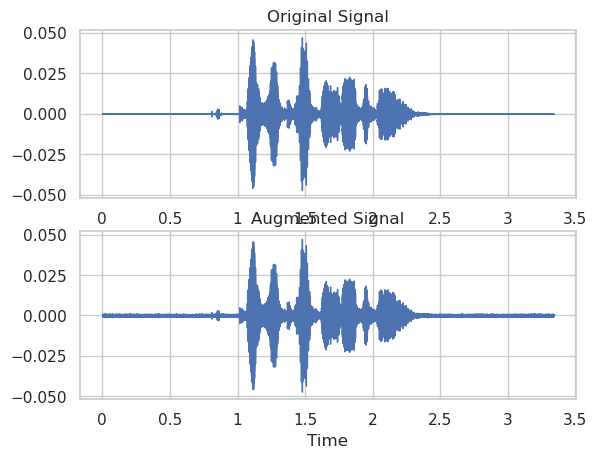

In [ ]:
path = np.array(data_path.path)[1]
data, sr = librosa.load(path)
augmented_signal = noise(data)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

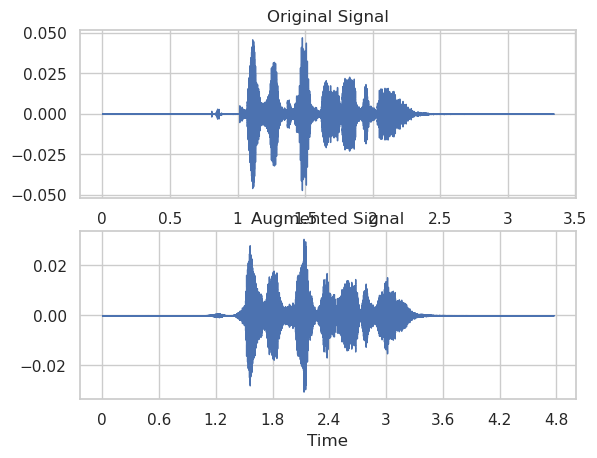

In [ ]:
path = np.array(data_path.path)[1]
data, sr = librosa.load(path)
augmented_signal = stretch(data)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

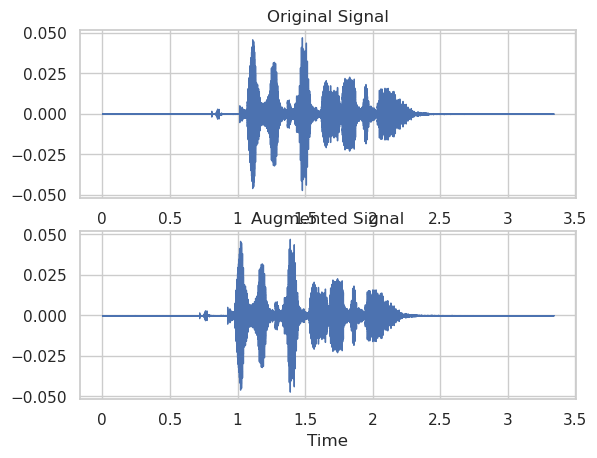

In [ ]:
path = np.array(data_path.path)[1]
data, sr = librosa.load(path)
augmented_signal = shift(data)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

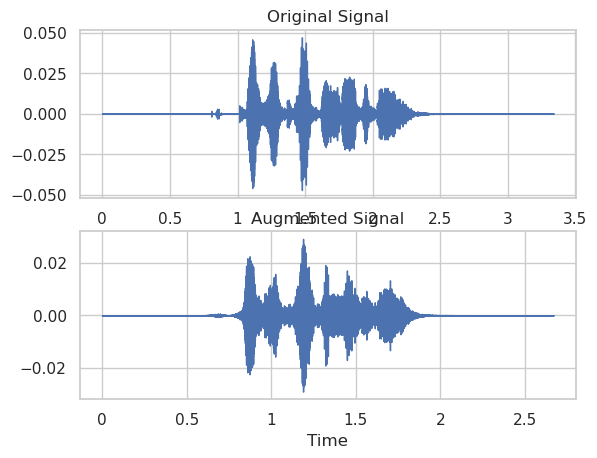

In [ ]:
path = np.array(data_path.path)[1]
data, sr = librosa.load(path)
augmented_signal = higher_speed(data)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

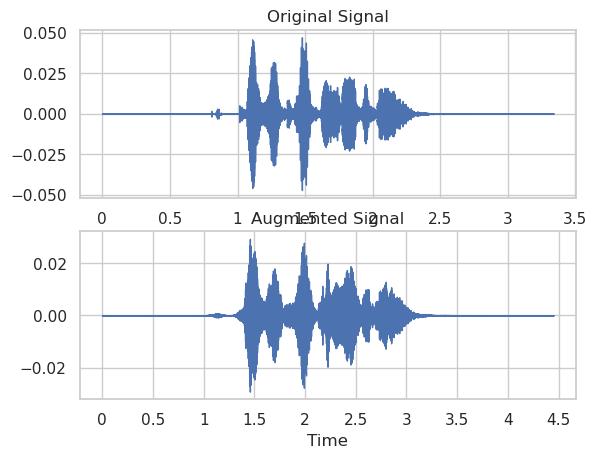

In [ ]:
path = np.array(data_path.path)[1]
data, sr = librosa.load(path)
augmented_signal = lower_speed(data)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

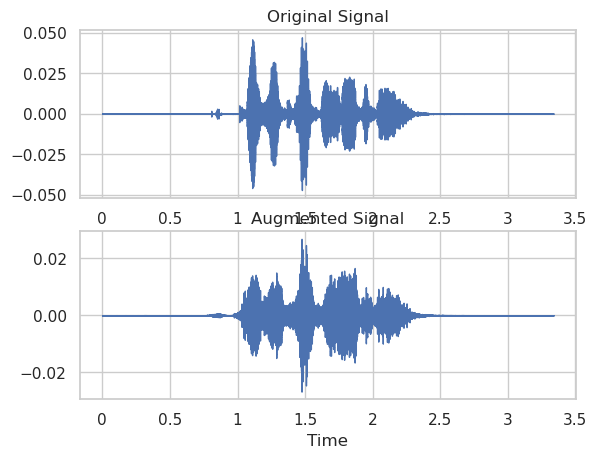

In [ ]:
path = np.array(data_path.path)[1]
data, sr = librosa.load(path)
augmented_signal = pitch(data,22050)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

In [ ]:
Audio(data, rate=sr)

In [ ]:
Audio(noise(data), rate=sr)

In [ ]:
Audio(shift(data), rate=sr)

In [ ]:
Audio(stretch(data), rate=sr)

In [ ]:
Audio(lower_speed(data), rate=sr)

In [ ]:
Audio(higher_speed(data), rate=sr)

In [ ]:
Audio(pitch(data,22050), rate=sr)

<h1><B><font color = 'darkblue'> Feature Extraction </b></font></h1>

Since I've already outlined the various types of features here, I'll just simplify things here and just use MFCC, because its the best feature for this particular problem

<h2><B><font color = 'darkblue'> - MFCC </b></font></h2>
MFCC is well known to be a good feature. And there's many ways you can slice and dice this one feature. But what is MFCC? It stands for Mel-frequency cepstral coefficient, and it is a good "representation" of the vocal tract that produces the sound. Think of it like an x-ray of your mouth

This post has a good deep dive into the MFCC should you wish to. The most common machine learning application treats the MFCC itself as an 'image' and becomes a feature. The benefit of treating it as an image is that it provides more information, and gives one the ability to draw on transfer learning. This is certainly legit and yields good accuracy. However, research has also shown that statistics relating to MFCCs (or any other time or frequency domain) can carry good amount of information as well. We'll be investigating both of this methods

In [ ]:
#sample_rate = 22050

def extract_features(data):

    result = np.array([])

    mfccs = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=58)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    result = np.array(mfccs_processed)

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=3, offset=0.5)

    #without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    #noised
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    #stretched
    stretch_data = stretch(data)
    res3 = extract_features(stretch_data)
    result = np.vstack((result, res3))

    #shifted
    shift_data = shift(data)
    res4 = extract_features(shift_data)
    result = np.vstack((result, res4))

    #pitched
    pitch_data = pitch(data, sample_rate)
    res5 = extract_features(pitch_data)
    result = np.vstack((result, res5))

    #speed up
    higher_speed_data = higher_speed(data)
    res6 = extract_features(higher_speed_data)
    result = np.vstack((result, res6))

    #speed down
    lower_speed_data = higher_speed(data)
    res7 = extract_features(lower_speed_data)
    result = np.vstack((result, res7))

    return result

In [ ]:
X, Y = [], []

for path, emotion in zip(data_path.path, data_path.labels):
    features = get_features(path)
    for feature in features:
        X.append(feature)
        # appending emotion 5 times as we have made 5 augmentation techniques on each audio file.
        Y.append(emotion)

In [ ]:
len(X), len(Y), data_path.path.shape

(85134, 85134, (12162,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('New_Features.csv', index=False)
print(len(Features))
Features.head()

85134


,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,labels
0,-667.117126,79.265198,0.214563,14.969451,8.738844,1.614774,-1.532765,-7.318048,-9.807105,-5.784626,...,-2.586592,-4.365417,-3.526463,-3.893123,-1.308869,-1.534479,0.177820,-1.924504,-0.712043,male_neutral
1,-486.731916,38.678597,10.171770,9.089673,4.433545,1.403211,-1.581564,-7.312235,-7.945420,-5.601044,...,-2.470251,-2.842615,-2.802495,-2.809910,-1.465030,-0.726356,-0.137324,-0.834978,-0.472595,male_neutral
2,-687.362793,75.290352,-1.210264,14.314219,8.129561,0.945795,-2.258028,-8.516194,-10.246474,-6.361144,...,-2.553753,-4.103726,-3.207460,-3.594904,-1.535072,-1.503656,0.118786,-1.881907,-0.801992,male_neutral
3,-666.781189,79.105919,0.098188,14.904655,8.758147,1.487837,-1.586403,-7.435553,-9.828020,-5.723872,...,-2.641448,-4.404100,-3.598511,-3.928404,-1.318374,-1.553680,0.184150,-1.942539,-0.744472,male_neutral
4,-693.085693,76.648788,-2.235734,15.661802,6.219852,0.362040,-5.023983,-10.431814,-11.020267,-4.200710,...,-3.485274,-5.102743,-1.389806,-1.083113,0.435190,-1.434615,-0.911742,-1.479177,1.416159,male_neutral


<h2><b><font color = 'darkblue'>Data Preparation</b></h2>

In [ ]:
Features = pd.read_csv('/kaggle/input/newdatasets/New_Features.csv')
Features

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,labels
0,-667.117126,79.265198,0.214563,14.969451,8.738844,1.614774,-1.532765,-7.318048,-9.807105,-5.784626,...,-2.586592,-4.365417,-3.526463,-3.893123,-1.308869,-1.534479,0.177820,-1.924504,-0.712043,male_neutral
1,-407.574165,23.809666,10.830092,6.974010,3.427679,1.863514,-1.460337,-5.146388,-6.388202,-4.585020,...,-2.350804,-2.120331,-2.770611,-2.180943,-1.182497,-0.634106,-0.254267,-0.513822,-0.106032,male_neutral
2,-687.362793,75.290352,-1.210264,14.314219,8.129561,0.945795,-2.258028,-8.516194,-10.246474,-6.361144,...,-2.553753,-4.103726,-3.207460,-3.594904,-1.535072,-1.503656,0.118786,-1.881907,-0.801992,male_neutral
3,-667.303345,79.338623,0.108453,15.009537,8.758369,1.515849,-1.553606,-7.425676,-9.832697,-5.729956,...,-2.600850,-4.390324,-3.556926,-3.911521,-1.313280,-1.559114,0.175841,-1.911970,-0.718179,male_neutral
4,-693.085693,76.648788,-2.235734,15.661802,6.219852,0.362040,-5.023983,-10.431814,-11.020267,-4.200710,...,-3.485274,-5.102743,-1.389806,-1.083113,0.435190,-1.434615,-0.911742,-1.479177,1.416159,male_neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85129,-535.529419,147.678757,4.125548,41.282303,17.964502,-11.436424,-23.290176,-10.401312,-20.307558,-16.549686,...,4.558703,5.847288,5.931197,4.891540,7.800804,8.906653,7.175795,6.862854,7.903193,male_happy
85130,-503.113525,140.602478,8.584867,39.555187,18.670259,-10.477264,-22.031979,-10.453458,-18.403437,-16.071764,...,3.820829,4.760688,5.239714,5.047496,7.335730,8.159767,6.683104,6.523489,7.594028,male_happy
85131,-529.508423,149.243805,1.640323,43.740406,12.895799,-14.372314,-24.122408,-11.195656,-23.619652,-12.793048,...,7.092883,6.771282,6.040644,8.963752,9.710288,6.482086,6.156532,6.609172,4.485556,male_happy
85132,-518.020935,149.392151,5.166693,41.144249,16.747551,-11.291153,-22.993483,-12.438994,-20.976929,-16.510225,...,4.798247,5.194843,5.292653,4.442547,7.593217,9.390950,7.236876,6.638849,8.072015,male_happy


In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
#from imblearn.over_sampling import SMOTE
#from collections import Counter

#sm = SMOTE(random_state=42)

#X_res, y_res = sm.fit_resample(X, Y)
#print("Original Data: ", Counter(Y))
#print("After Over Sampling: ", Counter(y_res))

In [ ]:
encoder = OneHotEncoder()
Y_res = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_res,test_size = 0.2, random_state=42, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((68107, 58), (68107, 14), (17027, 58), (17027, 14))

In [ ]:
#scaler = StandardScaler()
#x_train = scaler.fit_transform(x_train)
#x_test = scaler.transform(x_test)
#x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((68107, 58, 1), (68107, 14), (17027, 58, 1), (17027, 14))

<h2><b><font color = 'darkblue'>Model</b></h2>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM, Bidirectional
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

In [ ]:
model = Sequential()
model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(x_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(14, activation="softmax"))


model.compile(optimizer = 'RMSprop' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 512)           3072      
                                                                 
 batch_normalization (BatchN  (None, 58, 512)          2048      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 29, 512)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 29, 512)           1311232   
                                                                 
 batch_normalization_1 (Batc  (None, 29, 512)          2048      
 hNormalization)                                                 
                                                        

In [ ]:
rlrp = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
earlystopping = EarlyStopping(monitor ="val_accuracy",
                              mode = 'auto', patience = 5,
                              restore_best_weights = True)

history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp,earlystopping])

Epoch 1/50
1065/1065 [==============================] - 35s 17ms/step - loss: 1.4764 - accuracy: 0.4743 - val_loss: 1.5097 - val_accuracy: 0.4536 - lr: 0.0010
Epoch 2/50
1065/1065 [==============================] - 18s 17ms/step - loss: 1.1702 - accuracy: 0.5646 - val_loss: 1.3048 - val_accuracy: 0.5275 - lr: 0.0010
Epoch 3/50
1065/1065 [==============================] - 17s 16ms/step - loss: 1.0466 - accuracy: 0.6072 - val_loss: 1.0900 - val_accuracy: 0.5887 - lr: 0.0010
Epoch 4/50
1065/1065 [==============================] - 18s 17ms/step - loss: 0.9369 - accuracy: 0.6489 - val_loss: 0.9548 - val_accuracy: 0.6471 - lr: 0.0010
Epoch 5/50
1065/1065 [==============================] - 18s 17ms/step - loss: 0.8350 - accuracy: 0.6894 - val_loss: 0.9137 - val_accuracy: 0.6570 - lr: 0.0010
Epoch 6/50
1065/1065 [==============================] - 19s 18ms/step - loss: 0.7337 - accuracy: 0.7287 - val_loss: 0.9309 - val_accuracy: 0.6759 - lr: 0.0010
Epoch 7/50
1065/1065 [========================

<h2><b><font color = 'darkblue'>Evaluating our model</b></h2>

533/533 [==============================] - 3s 5ms/step - loss: 0.4206 - accuracy: 0.9340
Accuracy of our model on test data :  93.4 %


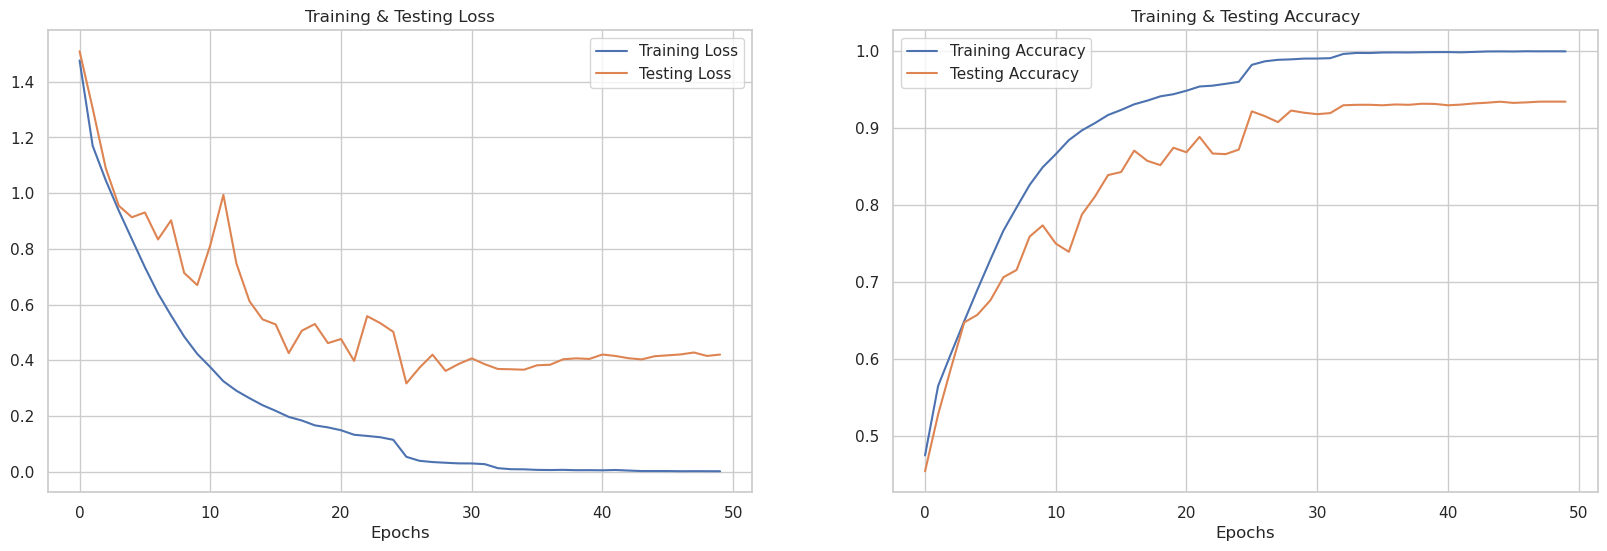

In [ ]:
print("Accuracy of our model on test data : " , round(model.evaluate(x_test,y_test)[1]*100,2) , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


<h2><b><font color = 'darkblue'>Save our model</b></h2>

In [ ]:
# Save model and weights
model_name = 'Emotion_Model_conv1d_gender_93.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("Emotion_Model_conv1d_gender_93.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /kaggle/working/saved_models/Emotion_Model_conv1d_gender_93.h5 


<h2><b><font color = 'darkblue'>Loading our model</b></h2>

In [ ]:
# loading json and model architecture
json_file = open('/kaggle/working/Emotion_Model_conv1d_gender_93.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/kaggle/working/saved_models/Emotion_Model_conv1d_gender_93.h5")
print("Loaded model from disk")

# Keras optimiser
loaded_model.compile(optimizer = 'RMSprop' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
score = loaded_model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 93.40%


<h2><b><font color = 'darkblue'>Model's prediction</b></h2>

In [ ]:
preds = model.predict(x_test)

533/533 [==============================] - 2s 3ms/step


In [ ]:
# predicting on test data.
y_pred = encoder.inverse_transform(preds)
y_tmp = encoder.inverse_transform(y_test)

In [ ]:
final_df = pd.DataFrame(columns=['PredictedLabels', 'ActualLabels'])
final_df['PredictedLabels'] = y_pred.flatten()
final_df['ActualLabels'] = y_tmp.flatten()

final_df

,PredictedLabels,ActualLabels
0,female_sad,female_sad
1,female_happy,female_happy
2,male_fear,male_fear
3,female_sad,female_sad
4,female_angry,female_angry
...,...,...
17022,male_angry,male_angry
17023,male_disgust,male_happy
17024,female_disgust,female_disgust
17025,male_sad,male_sad


<h2><b><font color = 'darkblue'>Evaluating our model on emotions</b></h2>

Accuracy of our model on test data based on emotions:  94.0 %


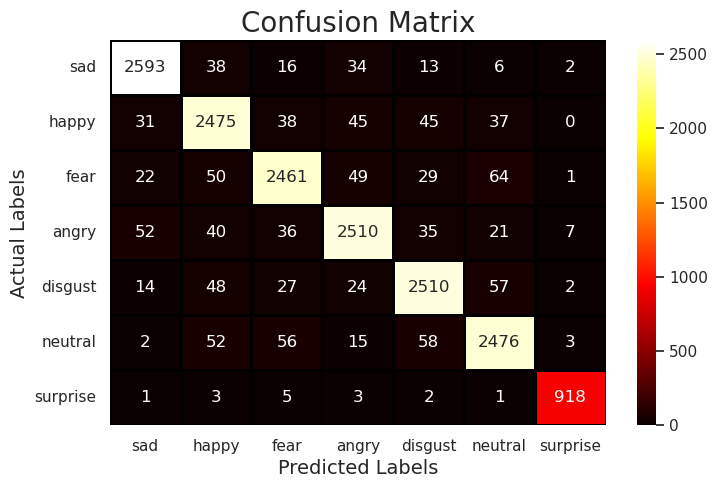

In [ ]:
modidf = final_df
modidf['ActualLabels'] = final_df.ActualLabels.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['PredictedLabels'] = final_df.PredictedLabels.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.ActualLabels.unique()
classes.sort()

# Confusion matrix
c = confusion_matrix(modidf.ActualLabels, modidf.PredictedLabels)
print("Accuracy of our model on test data based on emotions: " ,round(accuracy_score(modidf.ActualLabels, modidf.PredictedLabels),2)*100,"%")

#cm = confusion_matrix(y_tmp, y_pred)
plt.figure(figsize = (8, 5))
c = pd.DataFrame(c , index = [i for i in modidf['ActualLabels'].unique()] , columns = [i for i in modidf['PredictedLabels'].unique()])
sns.heatmap(c, linecolor='Black', cmap='hot', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(modidf.ActualLabels, modidf.PredictedLabels))

              precision    recall  f1-score   support

       angry       0.96      0.96      0.96      2702
     disgust       0.91      0.93      0.92      2671
        fear       0.93      0.92      0.93      2676
       happy       0.94      0.93      0.93      2701
     neutral       0.93      0.94      0.93      2682
         sad       0.93      0.93      0.93      2662
    surprise       0.98      0.98      0.98       933

    accuracy                           0.94     17027
   macro avg       0.94      0.94      0.94     17027
weighted avg       0.94      0.94      0.94     17027



<h2><b><font color = 'darkblue'>Evaluating our model on gender</b></h2>

In [ ]:
final_df = pd.DataFrame(columns=['PredictedLabels', 'ActualLabels'])
final_df['PredictedLabels'] = y_pred.flatten()
final_df['ActualLabels'] = y_tmp.flatten()

final_df

,PredictedLabels,ActualLabels
0,female_sad,female_sad
1,female_happy,female_happy
2,male_fear,male_fear
3,female_sad,female_sad
4,female_angry,female_angry
...,...,...
17022,male_angry,male_angry
17023,male_disgust,male_happy
17024,female_disgust,female_disgust
17025,male_sad,male_sad


Accuracy of our model on test data based on gender:  99.0 %


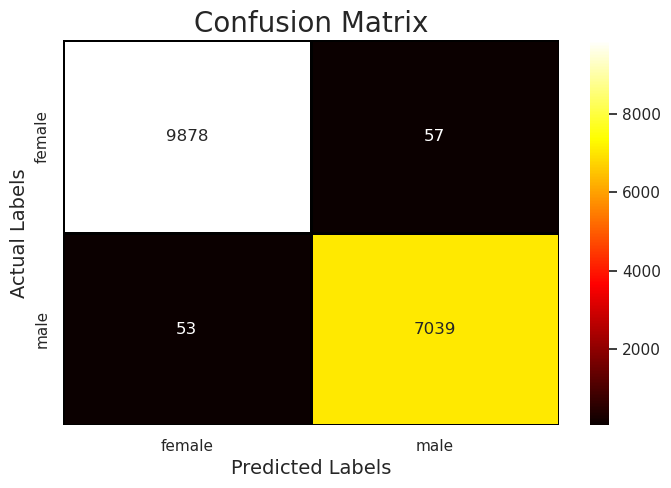

In [ ]:
modidf = final_df
modidf['ActualLabels'] = final_df.ActualLabels.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['PredictedLabels'] = final_df.PredictedLabels.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.ActualLabels.unique()
classes.sort()

# Confusion matrix
c = confusion_matrix(modidf.ActualLabels, modidf.PredictedLabels)
print("Accuracy of our model on test data based on gender: " ,round(accuracy_score(modidf.ActualLabels, modidf.PredictedLabels),2)*100,"%")

#cm = confusion_matrix(y_tmp, y_pred)
plt.figure(figsize = (8, 5))
c = pd.DataFrame(c , index = [i for i in modidf['ActualLabels'].unique()] , columns = [i for i in modidf['PredictedLabels'].unique()])
sns.heatmap(c, linecolor='Black', cmap='hot', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(modidf.ActualLabels, modidf.PredictedLabels))

              precision    recall  f1-score   support

      female       0.99      0.99      0.99      9935
        male       0.99      0.99      0.99      7092

    accuracy                           0.99     17027
   macro avg       0.99      0.99      0.99     17027
weighted avg       0.99      0.99      0.99     17027

